In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengolib
from nengolib import RLS, Network

In [36]:
# Task parameters
pulse_interval = 1.0
amplitude = 0.1
freq = 3.0
decay = 2.0
dt = 0.002
trials_train = 3
trials_test = 2

# Fixed model parameters
n = 200
seed = 0
rng = np.random.RandomState(seed)
ens_kwargs = dict(  # neuron parameters
    n_neurons=n,
    dimensions=1,
    neuron_type=nengo.LIF(),  # nengolib.neurons.Tanh()
    intercepts=[-1]*n,  
    seed=seed,
)

# Hyper-parameters
tau = 0.1                   # lowpass time-constant (10ms in [1])
tau_learn = 0.1             # filter for error / learning (needed for spiking)
tau_probe = 0.05            # filter for readout (needed for spiking
learning_rate = 0.1         # 1 in [1]
g = 1.5 / 4000               # 1.5 in [1], scaled by firing rates
g_in = tau / amplitude      # scale the input encoders (usually 1)
g_out = 0.1                 # scale the recurrent encoders (usually 1)

# Pre-computed constants
T_train = trials_train * pulse_interval
T_total = (trials_train + trials_test) * pulse_interval
print(T_train)
print(T_total)

3.0
5.0


In [37]:
with Network(seed=seed) as model:
    # Input is a pulse every pulse_interval seconds
    rng = np.random.RandomState(seed=seed)
    U = nengo.dists.UniformHypersphere(surface=False).sample(3, 1, rng=rng)
    
    u = nengo.Node(output=nengo.processes.PresentInput(U,  presentation_time=pulse_interval))

    # Desired output is a decaying oscillator
    z = nengo.Node(size_in=1)
    nengo.Connection(u, z, synapse=nengo.synapses.Alpha(0.05))

# Initial weights
e_in = g_in * rng.uniform(-1, +1, (n, 1))  # fixed encoders for f_in (u_in)
e_out = g_out * rng.uniform(-1, +1, (n, 1))  # fixed encoders for f_out (u)
JD = rng.randn(n, n) * g / np.sqrt(n)  # target-generating weights (variance g^2/n)


* xC are the neurons
* sC are the unfiltered currents into each neuron (sC -> Lowpass(tau) -> xC)
* zC is the learned output estimate, decoded by the neurons, and re-encoded back into sC alongside some random feedback (JD)
* eC is a gated error signal for RLS that turns off after T_train seconds. This error signal learns the feedback decoders by minmizing the difference between z (ideal output) and zC (actual output).

The error signal driving RLS has an additional filter applied (tau_learn) to handle the case when this signal consists of spikes (not rates).

In [38]:
with model:
    xC = nengo.Ensemble(**ens_kwargs)
    sC = nengo.Node(size_in=n)  # pre filter
    eC = nengo.Node(size_in=1, output=lambda t, e: e if t < T_train else 0)
    zC = nengo.Node(size_in=1)  # learned output

    nengo.Connection(u, sC, synapse=None, transform=e_in)
    nengo.Connection(sC, xC.neurons, synapse=tau)
    nengo.Connection(xC.neurons, sC, synapse=tau, transform=JD)  # chaos
    connC = nengo.Connection(
        xC.neurons, zC, synapse=None, transform=np.zeros((1, n)),
        learning_rule_type=RLS(learning_rate=learning_rate, pre_synapse=tau_learn))
    nengo.Connection(zC, sC, synapse=None, transform=e_out)

    nengo.Connection(zC, eC, synapse=None)  # actual
    nengo.Connection(z, eC, synapse=None, transform=-1)  # ideal
    nengo.Connection(eC, connC.learning_rule, synapse=tau_learn)

In [39]:
with model:
    # Probes
    p_u = nengo.Probe(u, synapse=tau_probe)
    p_z = nengo.Probe(z, synapse=tau_probe)
    p_e = nengo.Probe(eC, synapse=tau_probe)
    p_xC = nengo.Probe(xC, synapse=tau_probe)
    p_zC = nengo.Probe(zC, synapse=tau_probe)

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T_total)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

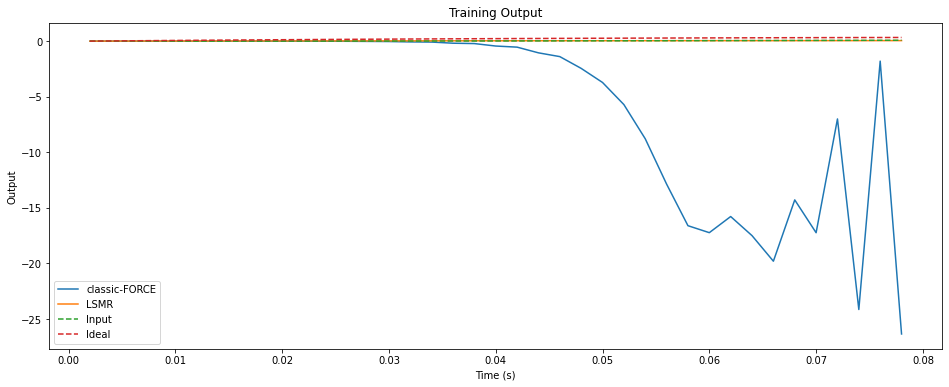

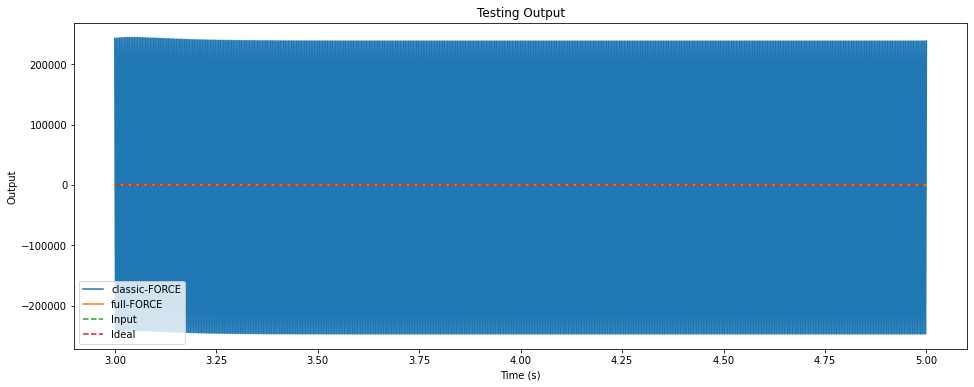

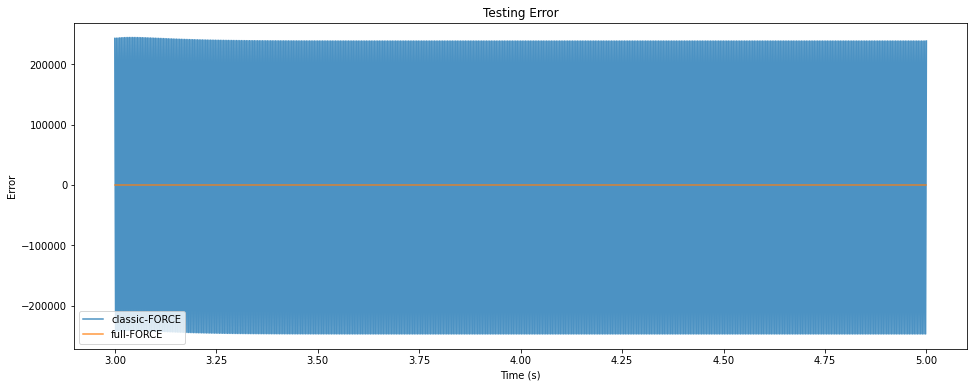

In [43]:


t_train = sim.trange() < 0.08
t_test = sim.trange() >= T_train

from nengo.utils.least_squares_solvers import LSMRScipy
solver = nengo.solvers.LstsqL2(solver=LSMRScipy(), reg=0.001)
wF, _ = solver(sim.data[p_u][t_train], sim.data[p_z][t_train])
zF = sim.data[p_u].dot(wF)

plt.figure(figsize=(16, 6))
plt.title("Training Output")
plt.plot(sim.trange()[t_train], sim.data[p_zC][t_train], label="classic-FORCE")
plt.plot(sim.trange()[t_train], zF[t_train], label="LSMR")
plt.plot(sim.trange()[t_train], sim.data[p_z][t_train], label="Input", linestyle='--')
plt.plot(sim.trange()[t_train], sim.data[p_u][t_train], label="Ideal", linestyle='--')

plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Testing Output")
plt.plot(sim.trange()[t_test], sim.data[p_zC][t_test], label="classic-FORCE")
plt.plot(sim.trange()[t_test], zF[t_test], label="full-FORCE")
plt.plot(sim.trange()[t_test], sim.data[p_z][t_test], label="Input", linestyle='--')
plt.plot(sim.trange()[t_test], sim.data[p_u][t_test], label="Ideal", linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Testing Error")
plt.plot(sim.trange()[t_test], sim.data[p_zC][t_test] - sim.data[p_z][t_test],
           alpha=0.8, label="classic-FORCE")
plt.plot(sim.trange()[t_test], zF[t_test] - sim.data[p_z][t_test],
           alpha=0.8, label="full-FORCE")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend()
plt.show()

* xD are the neurons that behave like classic FORCE in the ideal case (assuming the ideal output z is perfectly re-encoded)
* sD are the unfiltered currents into each neuron (sD -> Lowpass(tau) -> xD)

In [ ]:
with model:
    xD = nengo.Ensemble(**ens_kwargs)
    sD = nengo.Node(size_in=n)  # pre filter

    nengo.Connection(u, sD, synapse=None, transform=e_in)
    nengo.Connection(z, sD, synapse=None, transform=e_out)
    nengo.Connection(sD, xD.neurons, synapse=tau)
    nengo.Connection(xD.neurons, sD, synapse=None, transform=JD)

In [ ]:
with model:
    # Probes
    p_u = nengo.Probe(u, synapse=tau_probe)
    p_z = nengo.Probe(z, synapse=tau_probe)
    p_sD = nengo.Probe(sD, synapse=tau_probe)

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T_total)

In [ ]:
t_train = sim.trange() < T_train
t_test = sim.trange() >= T_train

plt.figure(figsize=(16, 6))
plt.title("Training Output")
plt.plot(sim.trange()[t_train], sim.data[p_u][t_train], label="Input", linestyle='--')
plt.plot(sim.trange()[t_train], sim.data[p_sD][t_train], label="Ensemble D")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.show()

* xF are the neurons
* sF are the unfiltered currents into each neuron (sF -> Lowpass(tau) -> xF)
* eF is a gated error signal for RLS that turns off after T_train seconds. This error signal learns the full-rank feedback weights by minimizing the difference between the unfiltered currents sD and sF.

The error signal driving RLS also has the same filter applied (tau_learn) to handle spikes. The output estimate is trained offline from the entire training set using batched least-squares, since this gives the best performance.

In [ ]:
with model:
    xF = nengo.Ensemble(**ens_kwargs)
    sF = nengo.Node(size_in=n)  # pre filter
    eF = nengo.Node(size_in=n, output=lambda t, e: e if t < T_train else np.zeros_like(e))
        
    nengo.Connection(u, sF, synapse=None, transform=e_in)
    nengo.Connection(sF, xF.neurons, synapse=tau)
    connF = nengo.Connection(
        xF.neurons, sF, synapse=None, transform=np.zeros((n, n)),
        learning_rule_type=RLS(learning_rate=learning_rate, pre_synapse=tau_learn))

    nengo.Connection(sF, eF, synapse=None)  # actual
    nengo.Connection(sD, eF, synapse=None, transform=-1)  # ideal
    nengo.Connection(eF, connF.learning_rule, synapse=tau_learn)

In [ ]:
with model:
    # Probes
    p_u = nengo.Probe(u, synapse=tau_probe)
    p_z = nengo.Probe(z, synapse=tau_probe)
    p_eF = nengo.Probe(eF, synapse=tau_probe)
    p_sF = nengo.Probe(sF, synapse=tau_probe)
    p_xF = nengo.Probe(xF.neurons, synapse=tau_probe)

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T_total)

In [ ]:
import matplotlib.pyplot as plt

t_train = sim.trange() < T_train
t_test = sim.trange() >= T_train

from nengo.utils.least_squares_solvers import LSMRScipy
solver = nengo.solvers.LstsqL2(solver=LSMRScipy(), reg=0.001)
wF, _ = solver(sim.data[p_xF][t_train], sim.data[p_z][t_train])
zF = sim.data[p_xF].dot(wF)

plt.figure(figsize=(16, 6))
plt.title("Training Output")
#plt.plot(sim.trange()[t_train], sim.data[p_xF][t_train], label="classic-FORCE")
plt.plot(sim.trange()[t_train], zF[t_train], label="full-FORCE")
plt.plot(sim.trange()[t_train], sim.data[p_z][t_train], label="Input", linestyle='--')
plt.plot(sim.trange()[t_train], sim.data[p_u][t_train], label="Idel", linestyle='--')
#plt.plot(sim.trange()[t_train], sim.data[p_e][t_train], label="Error")

plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Testing Output")
#plt.plot(sim.trange()[t_train], sim.data[p_xF][t_train], label="classic-FORCE")
plt.plot(sim.trange()[t_test], zF[t_test], label="full-FORCE")
plt.plot(sim.trange()[t_test], sim.data[p_z][t_test], label="Input", linestyle='--')
plt.plot(sim.trange()[t_test], sim.data[p_u][t_test], label="Ideal", linestyle='--')
#plt.plot(sim.trange()[t_train], sim.data[p_e][t_train], label="Error")

plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Testing Error")
#plt.plot(sim.trange()[t_test], sim.data[p_xF][t_test] - sim.data[p_z][t_test],
#           alpha=0.8, label="classic-FORCE")
plt.plot(sim.trange()[t_test], zF[t_test] - sim.data[p_z][t_test],
           alpha=0.8, label="full-FORCE")
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend()
plt.show()